In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, label_binarize
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import GridSearchCV
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

In [2]:
df = pd.read_csv('citibike_data/citibike_2018.csv')

In [5]:
len(df)

1752181

### Confusion Matrix function: 

In [13]:
def show_cf(y_true, y_pred, class_names=None, model_name=None):
    plt.figure(figsize=(20,15))
    cf = confusion_matrix(y_true, y_pred)
    plt.imshow(cf, cmap=plt.cm.Blues)
    
    if model_name:
        plt.title("Confusion Matrix: {}".format(model_name))
    else:
        plt.title("Confusion Matrix")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    class_names = set(y_true)
    tick_marks = np.arange(len(class_names))
    if class_names:
        plt.xticks(tick_marks, class_names)
        plt.yticks(tick_marks, class_names)
    
    thresh = cf.max() / 2.
    
    for i, j in itertools.product(range(cf.shape[0]), range(cf.shape[1])):
        plt.text(j, i, cf[i, j], horizontalalignment='center', color='white' if cf[i, j] > thresh else 'black')
    plt.xticks(rotation=90)
    plt.colorbar()

In [14]:
df_small = df.sample(5000)

Split variables from targets: 

In [16]:
labels = df_small.stop_nhbr

Use LabelEncoder to convert target labels into a categories: 

In [6]:
le = LabelEncoder()

In [17]:
#labels = le.fit_transform(labels.astype(str))
labels_removed_df = df_small.drop('stop_nhbr', axis=1)

In [19]:
labels.unique()

array(['SoHo', 'Upper West Side', 'Financial District', 'Midtown',
       'Chelsea', 'Battery Park', 'Crown Heights', 'Lower East Side',
       'Morningside Heights', 'Boerum Hill', 'East Village', 'Greenpoint',
       'Greenwich Village', 'Williamsburg', 'Garment District',
       'Columbus Circle', 'Fort Greene', 'Flatiron District',
       'Hunters Point', 'NoHo', 'Little Italy', 'West Village',
       'Upper East Side', 'Gramercy', 'Gowanus', 'Stuyvesant Town',
       'Murray Hill', 'Park Slope', 'Prospect Heights', 'Cobble Hill',
       'Tribeca', 'East Harlem', 'Downtown', 'Clinton', 'Red Hook',
       'Harlem', 'Turtle Bay', 'Chinatown', 'Tudor City', 'Navy Yard',
       'Carroll Gardens', 'Astoria', 'Clinton Hill', 'Sutton Place',
       'Central Park', 'Bedford Stuyvesant',
       'Columbia Street Waterfront District', 'DUMBO', 'Brooklyn Heights',
       'Sunnyside', 'Prospect Lefferts Gardens'], dtype=object)

Scale data: 

In [8]:
# scaler = StandardScaler()
# scaled_df = scaler.fit_transform(labels_removed_df)

Split data into training and testing sets.  Maintain at least some of each target class in both sets with the 'stratify' argument. 

In [9]:
X_train, X_test, y_train, y_test = train_test_split(labels_removed_df, labels)

Fit xgboost model: 

In [ ]:
clf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=6, min_samples_split=2, 
                                min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', 
                             max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, 
                             bootstrap=True, oob_score=False, n_jobs=None, random_state=42, verbose=0, 
                             warm_start=False, class_weight=None)

In [ ]:
clf.fit(X_train, y_train)

In [ ]:
training_preds = clf.predict(X_train)

In [ ]:
val_preds = clf.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
val_accuracy = accuracy_score(y_test, val_preds)

print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

In [ ]:
show_cf(y_test, val_preds)

In [ ]:
param_grid = {
    "criterion" : ['gini', 'entropy']
    'max_depth': [2, 3, 4],
    'min_child_weight': [4, 5],
    'n_estimators': [300, 400, 500],
}

In [ ]:
grid_clf = GridSearchCV(clf, param_grid, scoring='accuracy', cv=None, n_jobs=1)
eval_metric = ["auc", 'error']
eval_set = [(X_train, y_train), (X_test, y_test)]
grid_clf.fit(X_train, y_train, eval_set= eval_set, early_stopping_rounds=5)
best_parameters = grid_clf.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(X_train)
val_preds = grid_clf.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
val_accuracy = accuracy_score(y_test, val_preds)

print("")
print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

In [ ]:
val_preds

In [ ]:
clf.feature_importances_

In [ ]:
cf = confusion_matrix(y_test, val_preds)
cf

In [ ]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

plot_feature_importances(clf)

### Testing Roc and AUC curve plots

Fit a OneVsRest Classifier to our model: 

In [44]:
y = label_binarize(labels, classes= ['SoHo', 'Upper West Side', 'Financial District', 'Midtown',
       'Chelsea', 'Battery Park', 'Crown Heights', 'Lower East Side',
       'Morningside Heights', 'Boerum Hill', 'East Village', 'Greenpoint',
       'Greenwich Village', 'Williamsburg', 'Garment District',
       'Columbus Circle', 'Fort Greene', 'Flatiron District',
       'Hunters Point', 'NoHo', 'Little Italy', 'West Village',
       'Upper East Side', 'Gramercy', 'Gowanus', 'Stuyvesant Town',
       'Murray Hill', 'Park Slope', 'Prospect Heights', 'Cobble Hill',
       'Tribeca', 'East Harlem', 'Downtown', 'Clinton', 'Red Hook',
       'Harlem', 'Turtle Bay', 'Chinatown', 'Tudor City', 'Navy Yard',
       'Carroll Gardens', 'Astoria', 'Clinton Hill', 'Sutton Place',
       'Central Park', 'Bedford Stuyvesant',
       'Columbia Street Waterfront District', 'DUMBO', 'Brooklyn Heights',
       'Sunnyside', 'Prospect Lefferts Gardens'])
n_classes =y.shape[1]

# Learn to predict each class against the other
classifier = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=6, min_samples_split=2, 
                                min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', 
                             max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, 
                             bootstrap=True, oob_score=False, n_jobs=None, random_state=42, verbose=0, 
                             warm_start=False, class_weight=None))
y_score = classifier.fit(X_train, y_train).predict_proba(X_test)



Compute ROC curve and ROC area for each class

In [45]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:,i], y_score[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


Plot a single class on the curve:

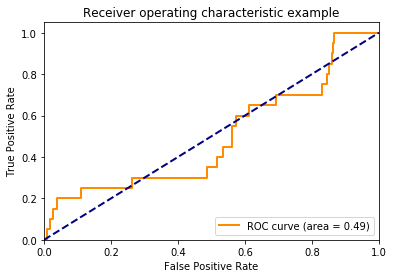

In [46]:
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Create a function to plot all classes on a single ROC plot:

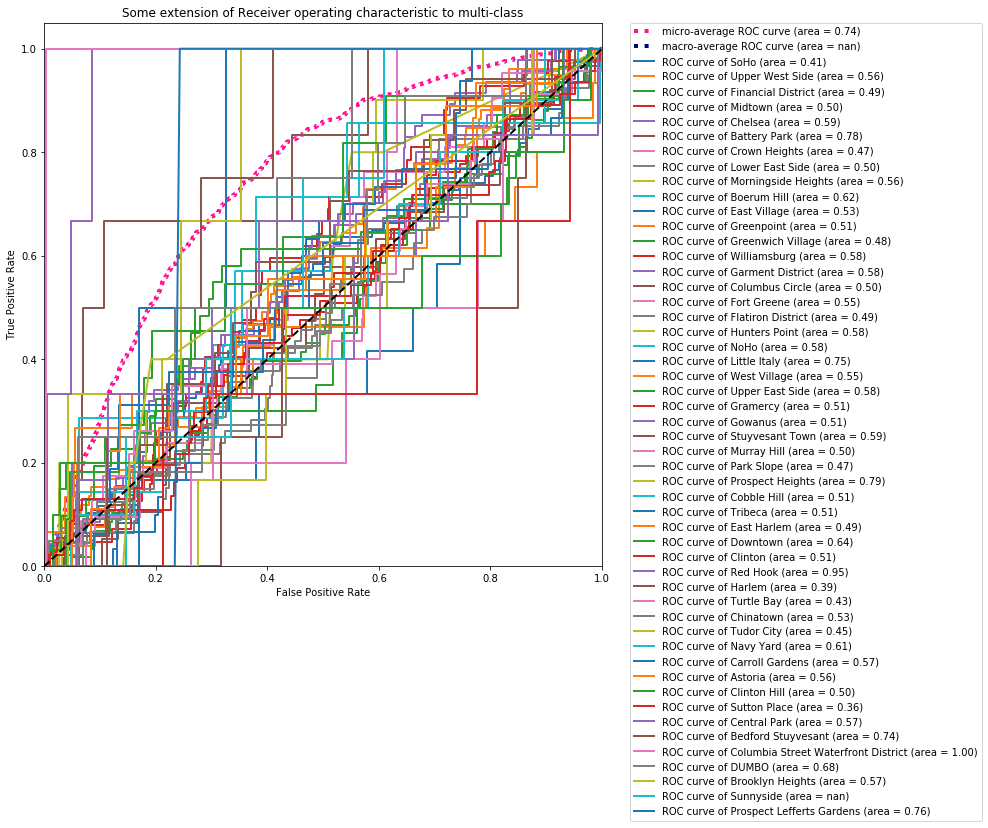

In [60]:
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(10,10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)
classes=['SoHo', 'Upper West Side', 'Financial District', 'Midtown',
       'Chelsea', 'Battery Park', 'Crown Heights', 'Lower East Side',
       'Morningside Heights', 'Boerum Hill', 'East Village', 'Greenpoint',
       'Greenwich Village', 'Williamsburg', 'Garment District',
       'Columbus Circle', 'Fort Greene', 'Flatiron District',
       'Hunters Point', 'NoHo', 'Little Italy', 'West Village',
       'Upper East Side', 'Gramercy', 'Gowanus', 'Stuyvesant Town',
       'Murray Hill', 'Park Slope', 'Prospect Heights', 'Cobble Hill',
       'Tribeca', 'East Harlem', 'Downtown', 'Clinton', 'Red Hook',
       'Harlem', 'Turtle Bay', 'Chinatown', 'Tudor City', 'Navy Yard',
       'Carroll Gardens', 'Astoria', 'Clinton Hill', 'Sutton Place',
       'Central Park', 'Bedford Stuyvesant',
       'Columbia Street Waterfront District', 'DUMBO', 'Brooklyn Heights',
       'Sunnyside', 'Prospect Lefferts Gardens']


for i, cl in zip(range(n_classes), classes):
    plt.plot(fpr[i], tpr[i], lw=lw,
             label='ROC curve of {0} (area = {1:0.2f})'
             ''.format(cl, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()